In [1]:
import numpy as np
from CIR import get_CIR
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np
from simulation import Simulation, Contract
from torch.utils.data import TensorDataset, Dataset, DataLoader
import Sandbox_utils as utils
import dataset_managment
import model_managment
import train_managment
import torch_geometric

from GCLSTM import GCLSTM

In [2]:
# Fix current device

device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device = 'cuda:0'



In [3]:
import argparse

def dict_to_args(dictionary):
    parser = argparse.ArgumentParser()
    
    for key, value in dictionary.items():
        parser.add_argument(f'--{key}', type=type(value), default=value)
    
    return parser.parse_args([])

In [4]:
args = { 
    'lookback' : 5,
    'num_nodes' : 5,
    'alpha' : 0.6,
    'b' : 0.04,
    'sigma' : 0.14,
    'v_0' : 0.04,
    'years' : 60,
    'gamma' : 3,
    'steps_ahead' : 5,
    'lstm_hidden_size' : 15,
    'regressor_hidden_size' : 512,
    'regressor_hidden_size_2' : 512,
    'number_regressor_layers' : 2,
    'input_size' : 36,
    'contract_size' : 6,
    'device': 'cuda:0',
    'batch_size' : 500
    
}

In [5]:
args = dict_to_args(args)

In [6]:
args.lookback

5

In [7]:
path_name = '/u/mcitterio/temp/Generative-models-for-financial-networks/NodeRegression/'
data_file_name = path_name + f'subgraphs_Duffie_{args.num_nodes}nodes_3gamma.pt'

In [8]:
cos = torch.load('./y_benchmark_5nodes.pt')

In [9]:
try:
    print(f'Retrieving data...')
    dataset = torch.load(path_name + f'subgraphs_Duffie_{args.num_nodes}nodes_3gamma.pt',  map_location=torch.device(device))

except:
    print('Error: the data file doesnt exist, please run `SimulateNetwork.py`')
    raise ValueError

# Generate CIR process & simulation
sim = Simulation(args.alpha, args.b, args.sigma, args.v_0, args.years, gamma = args.gamma, seed=True)
CIRProcess = torch.tensor(sim.CIRProcess.reshape(-1,1)).to(torch.float32).to(device)


Retrieving data...


In [10]:
# Train-test split
training_index = int(0.8 * len(dataset))

print('Dataset len: ', len(dataset))

#TRAIN
train_dataset = dataset[:training_index]

#TEST
test_dataset = dataset[training_index:]

Dataset len:  21806


In [11]:
cos.shape

torch.Size([21806, 5, 5])

In [12]:
#y_margin_train.shape

In [13]:
cos[0:10].shape

torch.Size([10, 5, 5])

In [14]:
# Slice dataset into windows
Contract_train, y_margin_train, r_train, y_bench_train = utils.create_graph_windows(args, device,cos, train_dataset)
Contract_test,y_margin_test, r_test, y_bench_test = utils.create_graph_windows(args, device,cos, test_dataset)

n_samples: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4353/4353 [00:00<00:00, 4966.48it/s]


In [15]:
#Dataset for the gc-lstm
gclstm_train_dataset = dataset_managment.DataSplit(args, train_dataset)
gclstm_test_dataset = dataset_managment.DataSplit(args, test_dataset)
torch.manual_seed(0)
gclstm_train_loader = torch_geometric.loader.DataLoader(gclstm_train_dataset, batch_size=1, shuffle=False)
gclstm_test_loader = torch_geometric.loader.DataLoader(gclstm_test_dataset, batch_size=1, shuffle=False)


In [30]:
train_dataset = TensorDataset(Contract_train.to(device), y_margin_train.to(device), r_train.to(device))
test_dataset = TensorDataset(Contract_test.to(device), y_margin_test.to(device), r_test.to(device), y_margin_test.to(device))

In [31]:
#Transform it into a dataloader
torch.manual_seed(0)
loader = DataLoader(train_dataset, shuffle=False, batch_size=1)
loader_test = DataLoader(test_dataset, shuffle=False, batch_size = 1)

In [32]:
mymodel = model_managment.CompleteModel(args).to(device)   

In channels:  1
Out channels:  15


In [19]:
mymodel.state_dict()

OrderedDict([('gclstm.recurrent_1.W_i',
              tensor([[-0.5888, -0.1952, -0.4092,  0.4769,  0.4413,  0.1453,  0.4976,  0.2949,
                       -0.5769, -0.0613, -0.0994, -0.3718,  0.1744, -0.1911, -0.2928]],
                     device='cuda:0')),
             ('gclstm.recurrent_1.b_i',
              tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
                     device='cuda:0')),
             ('gclstm.recurrent_1.W_f',
              tensor([[-0.0071, -0.4071,  0.5068,  0.3875,  0.5797, -0.1085,  0.2000, -0.0246,
                       -0.5067,  0.2770, -0.4277, -0.2211, -0.2742, -0.5974,  0.0220]],
                     device='cuda:0')),
             ('gclstm.recurrent_1.b_f',
              tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
                     device='cuda:0')),
             ('gclstm.recurrent_1.W_c',
              tensor([[ 0.1003, -0.0455,  0.4504,  0.0294, -0.1115, -0.3340, -0.3637, -0.0871,
         

In [33]:
mymodel.load_state_dict(torch.load('temp_state_dict555005.pt'))

<All keys matched successfully>

In [21]:
#torch.load('temp_state_dict51210.pt')

In [34]:
#Makes the predictions
def graph_predictions(args, model, loader, gc_loader):
    """
    Performs the model evalutation over the pytorch dataset

    Parameters
    ----------
    - dataset : `pytorch.Dataset`
        Dataset over which we want to base our prediction
    - model : `pytorch.nn.Module`
        model we want to use for the prediction
    """

    #Define a dataloader from the dataset without 


    #Define two tensors
    y_margin_preds = torch.zeros(len(loader), args.num_nodes, args.steps_ahead)
    y_margin_trues = torch.zeros(len(loader), args.num_nodes, args.steps_ahead)
    y_bench = torch.zeros(len(loader), args.num_nodes, args.steps_ahead)

    loop = tqdm(zip(gc_loader,loader), desc='Prediction')
    i_sample = 0
    
    for  batch_gc, (Contract_batch, y_margin_batch, r_batch, bench_batch) in loop:
        with torch.no_grad():

            intensity_embedding = model.gclstm(batch_gc)

            pred = model.lstm.forward_pred(Contract_batch, intensity_embedding.reshape(Contract_batch.shape[0], Contract_batch.shape[2], intensity_embedding.shape[1]), r_batch ).squeeze(0).cpu()
            

            # FOCUS ON FIXED LEG
            y_margin_preds[i_sample] = pred
            y_margin_trues[i_sample]  = y_margin_batch.squeeze(0).cpu()
            y_bench[i_sample] = bench_batch.squeeze(0).cpu()
            i_sample +=1
            
    return y_margin_trues.numpy(), y_margin_preds.numpy(), y_bench.numpy()

In [23]:
print('loader len: ',len(loader))

labels, preds = graph_predictions(args, mymodel, loader, gclstm_train_loader)

loader len:  17435


Prediction: 0it [00:00, ?it/s]

KeyboardInterrupt: 

Text(0, 0.5, '$M(t)$')

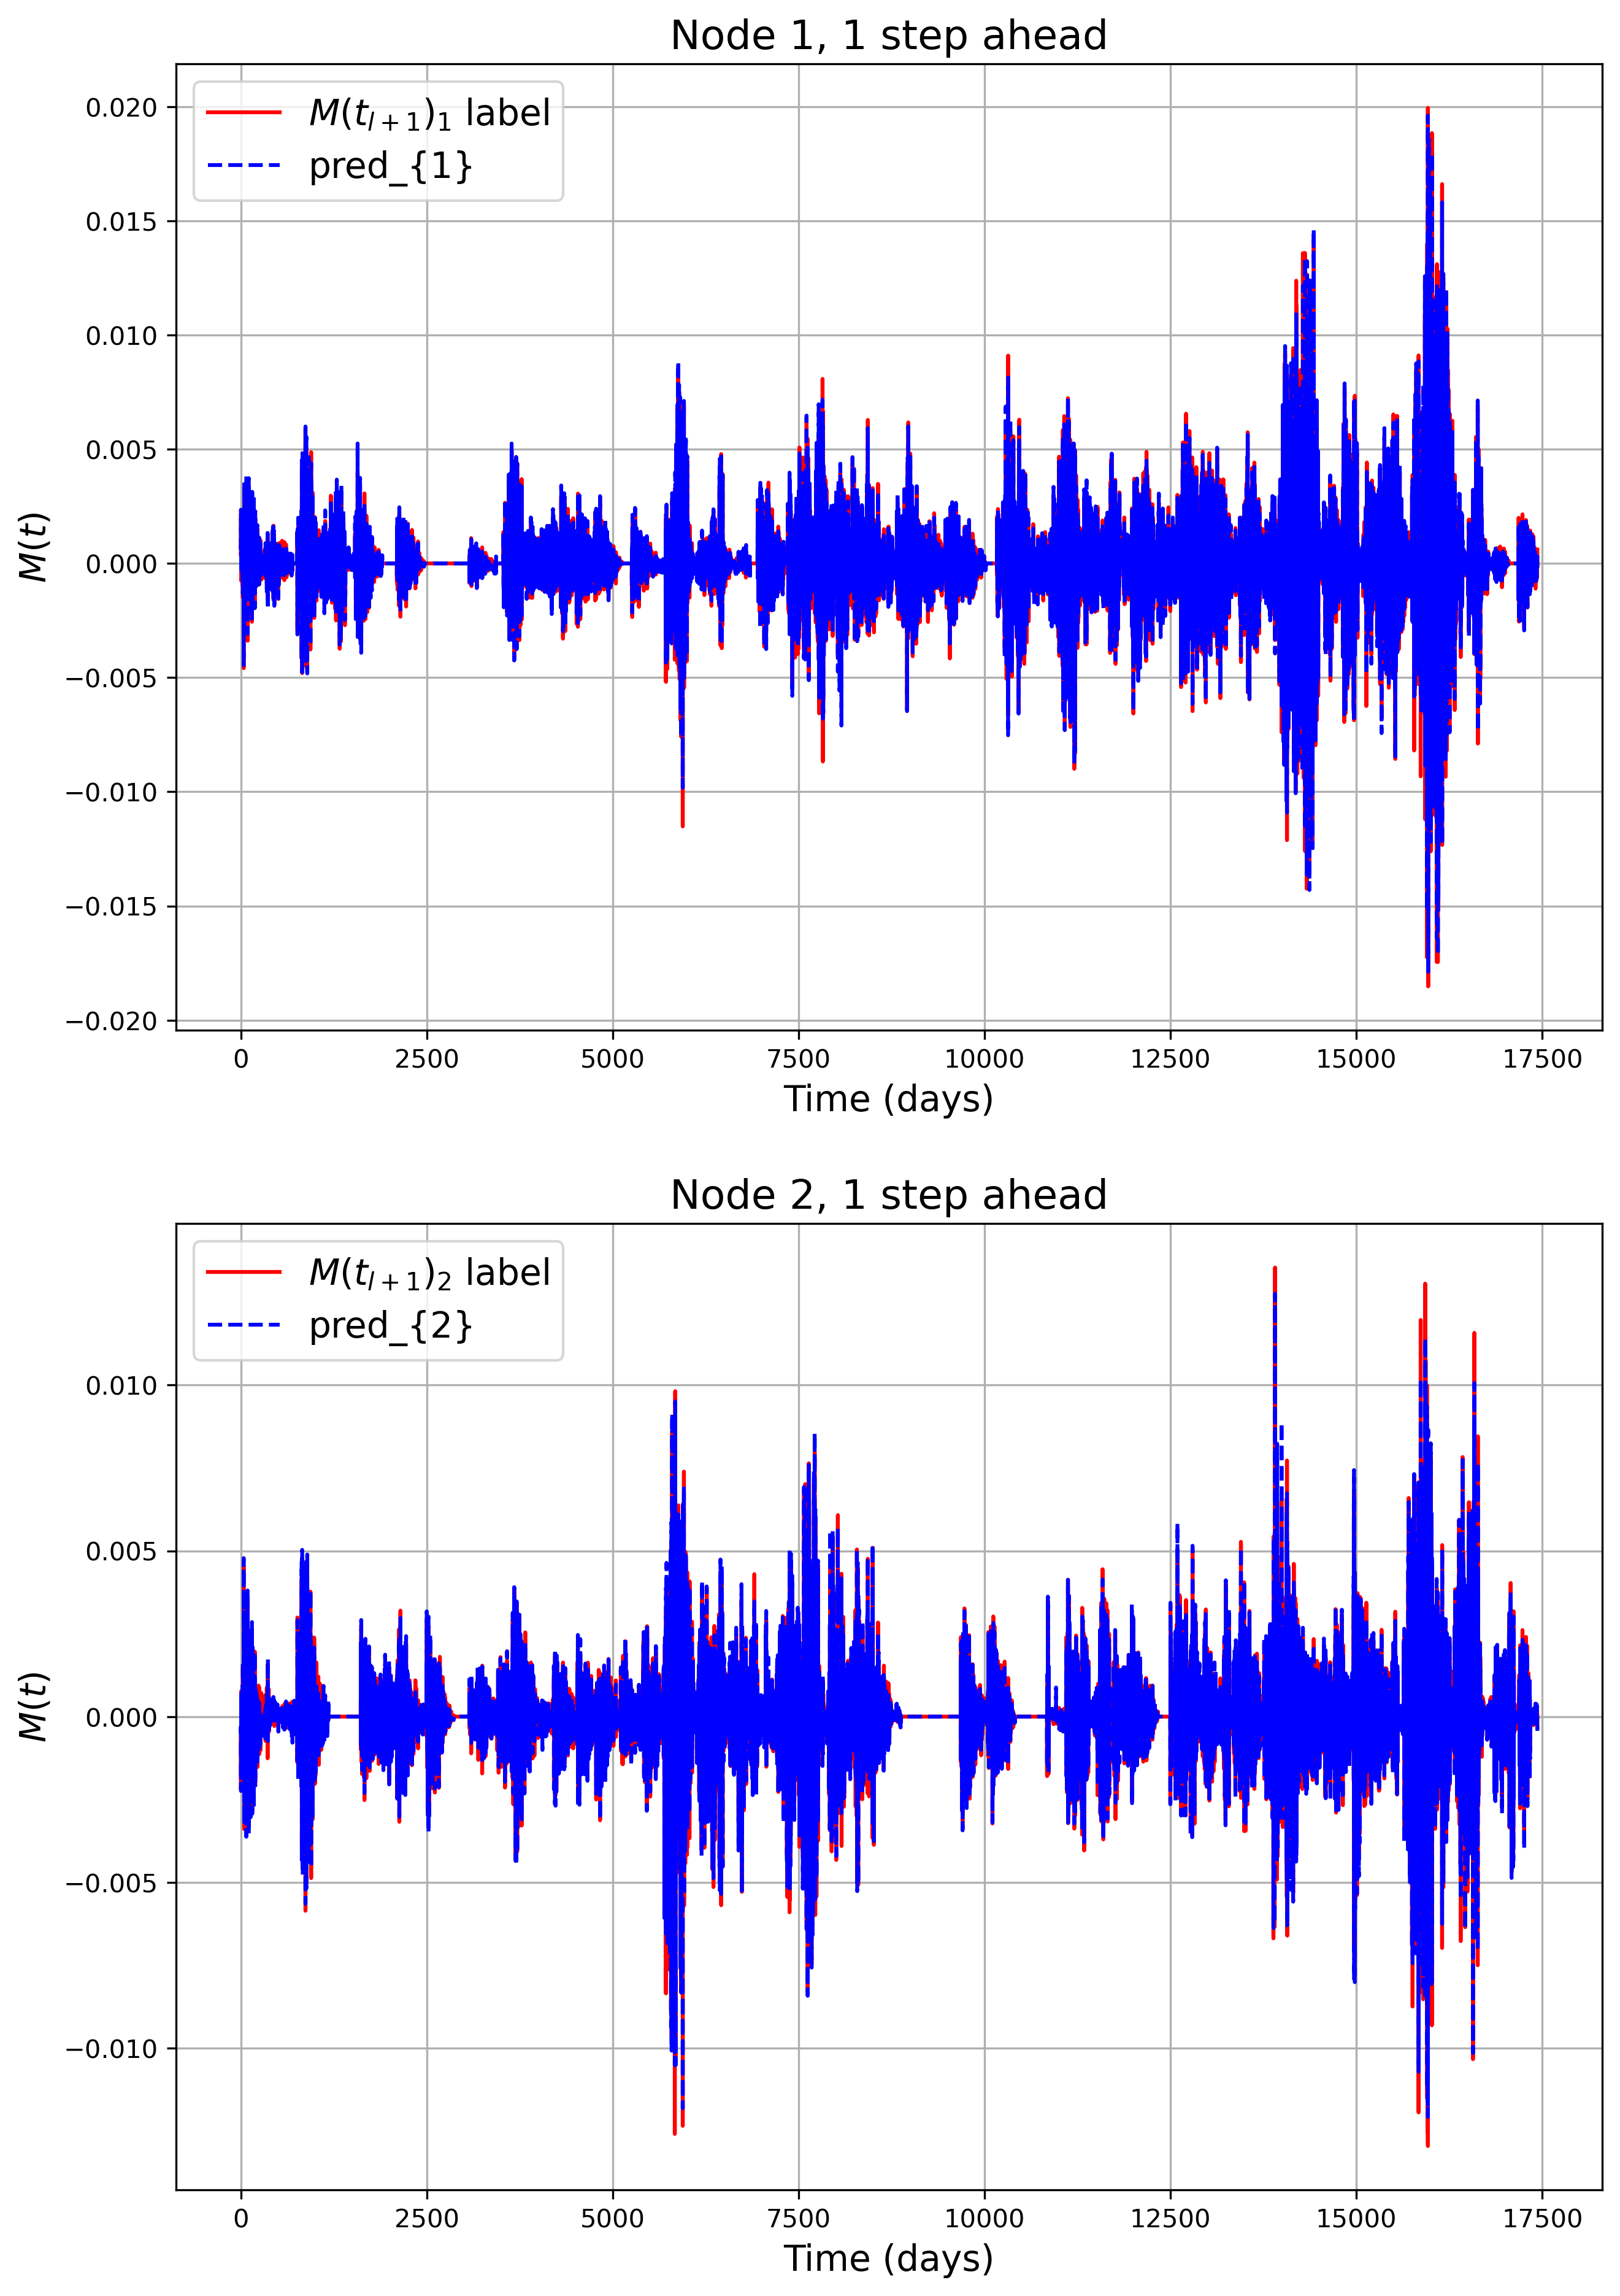

In [148]:
#Plot predictions (train)
plt.figure(figsize=(10,15), dpi=300)

plt.subplot(2,1,1)
plt.title('Node 1, 1 step ahead', fontsize=16)
plt.plot(labels[:,0,0], 'r-', label='$M(t_{l+1})_{1}$ label')
plt.plot(preds[:,0,0], 'b--', label='pred_{1}')
#plt.xlim(1200,1300)
#plt.ylim(0.0035,-0.0035)
plt.grid()
plt.legend(fontsize=14)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('$M(t)$', fontsize=14)

plt.subplot(2,1,2)
plt.title('Node 2, 1 step ahead', fontsize=16)
plt.plot(labels[:,1,0], 'r-', label='$M(t_{l+1})_{2}$ label')
plt.plot(preds[:,1,0], 'b--', label='pred_{2}')
#plt.xlim(1200,1300)
#plt.ylim(0.0035,-0.0035)
plt.grid()
plt.legend(fontsize=14)
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('$M(t)$', fontsize=14)

In [35]:
print('loader len: ',len(loader_test))

labels_test, preds_test, bench_test =graph_predictions(args, mymodel, loader_test, gclstm_test_loader)

loader len:  4353


Prediction: 0it [00:00, ?it/s]

In [36]:
labels_test.shape

(4353, 5, 5)

In [37]:
bench_test.shape

(4353, 5, 5)

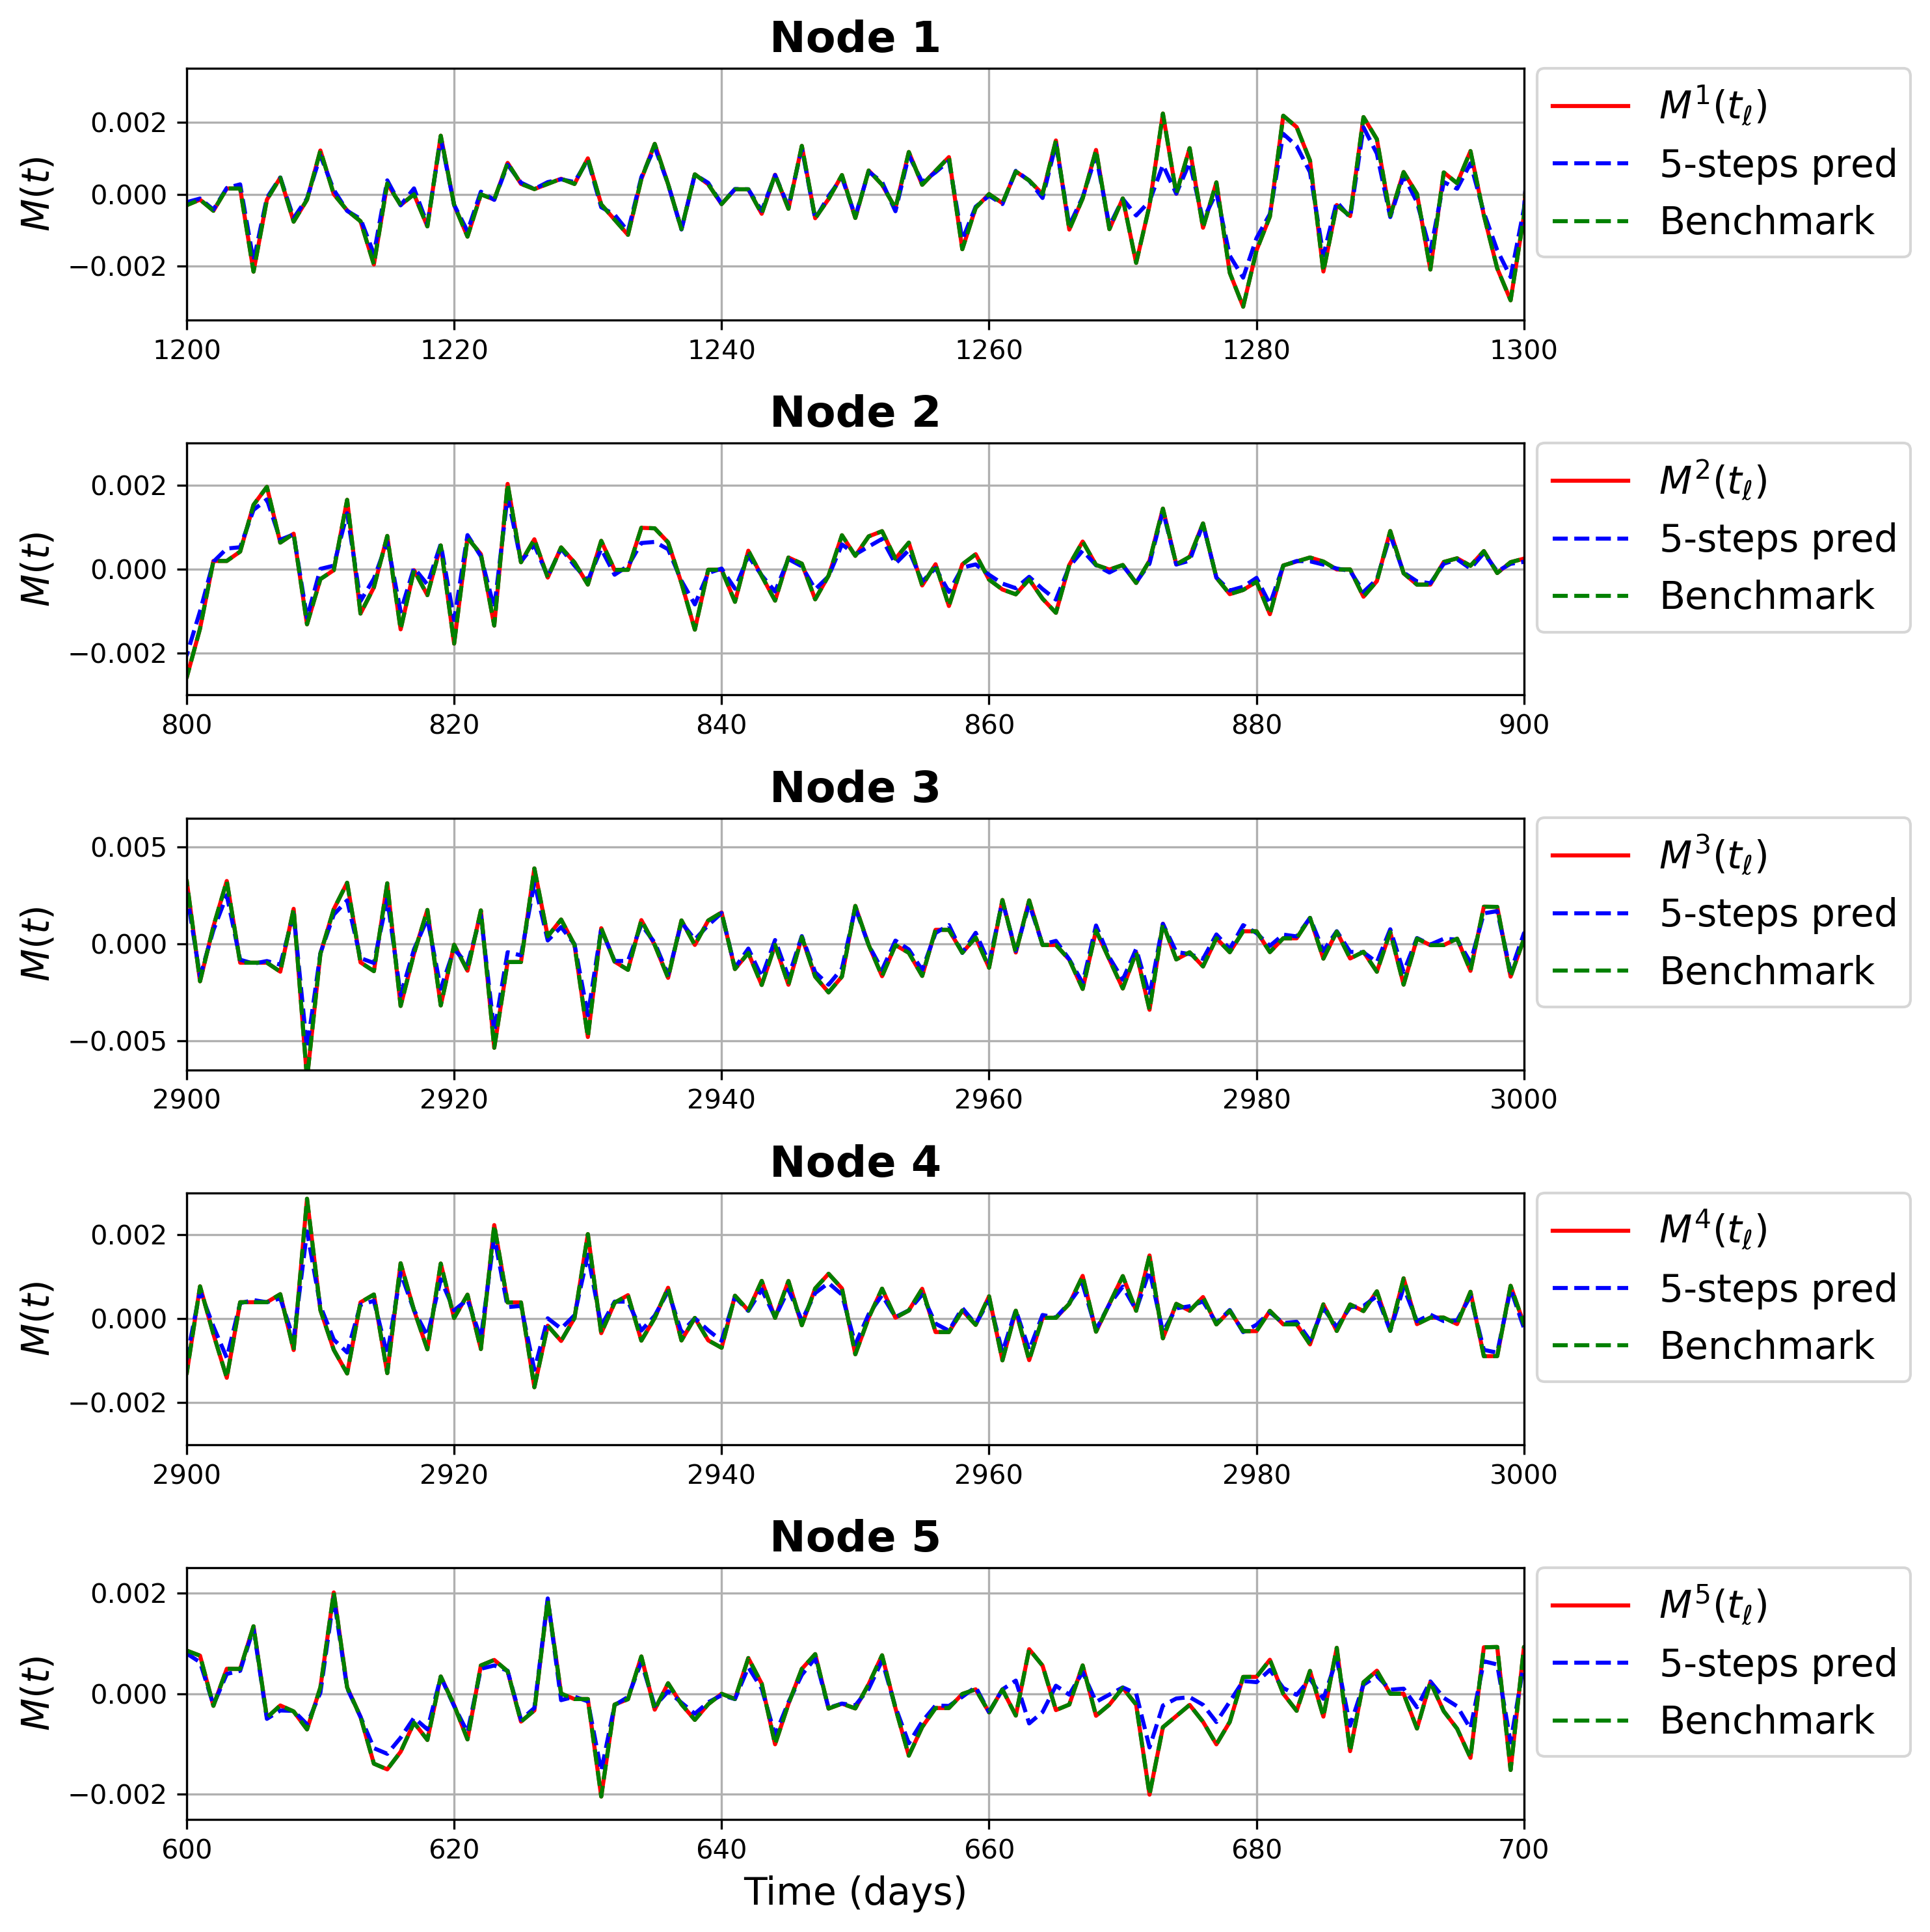

In [54]:
#Plot predictions (train)
plt.figure(figsize=(10,10), dpi=300)

plt.subplot(5,1,1)
plt.title('Node 1', fontsize=16, fontweight='bold')
plt.plot(labels_test[4:,0,0], 'r-', label='$M^1(t_{\ell})$')
plt.plot(preds_test[:,0,4], 'b--', label='$5$-steps pred')
plt.plot(bench_test[:,0,4],'g--', label='Benchmark')

plt.xlim(1200,1300)
plt.ylim(-0.0035,0.0035)
plt.grid()
plt.legend(fontsize=14,loc=(1.01,.25))
#plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('$M(t)$', fontsize=14)

plt.subplot(5,1,2)
plt.title('Node 2', fontsize=16, fontweight='bold')
plt.plot(labels_test[4:,1,0], 'r-', label='$M^2(t_{\ell})$')
plt.plot(preds_test[:,1,4], 'b--', label='$5$-steps pred')
plt.plot(bench_test[:,1,4],'g--', label='Benchmark')
plt.xlim(800,900)
plt.ylim(-0.003,+0.003)
plt.grid()
plt.legend(fontsize=14,loc=(1.01,.25))
#plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('$M(t)$', fontsize=14)

plt.subplot(5,1,3)
plt.title('Node 3', fontsize=16, fontweight='bold')
plt.plot(labels_test[4:,2,0], 'r-', label='$M^3(t_{\ell})$')
plt.plot(preds_test[:,2,4], 'b--', label='$5$-steps pred')
plt.plot(bench_test[:,2,4],'g--', label='Benchmark')
plt.xlim(2900,3000)
plt.ylim(-0.0065,+0.0065)
plt.grid()
plt.legend(fontsize=14, loc=(1.01,.25))
#plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('$M(t)$', fontsize=14)

plt.subplot(5,1,4)
plt.title('Node 4', fontsize=16, fontweight='bold')
plt.plot(labels_test[4:,3,0], 'r-', label='$M^4(t_{\ell})$')
plt.plot(preds_test[:,3,4], 'b--', label='$5$-steps pred')
plt.plot(bench_test[:,3,4],'g--', label='Benchmark')
plt.xlim(2900,3000)
plt.ylim(-0.003,+0.003)
plt.grid()
plt.legend(fontsize=14,loc=(1.01,.25))
#plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('$M(t)$', fontsize=14)

plt.subplot(5,1,5)
plt.title('Node 5', fontsize=16, fontweight='bold')
plt.plot(labels_test[4:,4,0], 'r-', label='$M^5(t_{\ell})$')
plt.plot(preds_test[:,4,4], 'b--', label='$5$-steps pred')
plt.plot(bench_test[:,4,4],'g--', label='Benchmark')
plt.xlim(600,700)
plt.ylim(-0.0025,+0.0025)
plt.grid()
plt.legend(fontsize=14, loc=(1.01,.25))
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('$M(t)$', fontsize=14)

plt.tight_layout()

plt.savefig('5_nodes_5_steps.pdf')

plt.show()

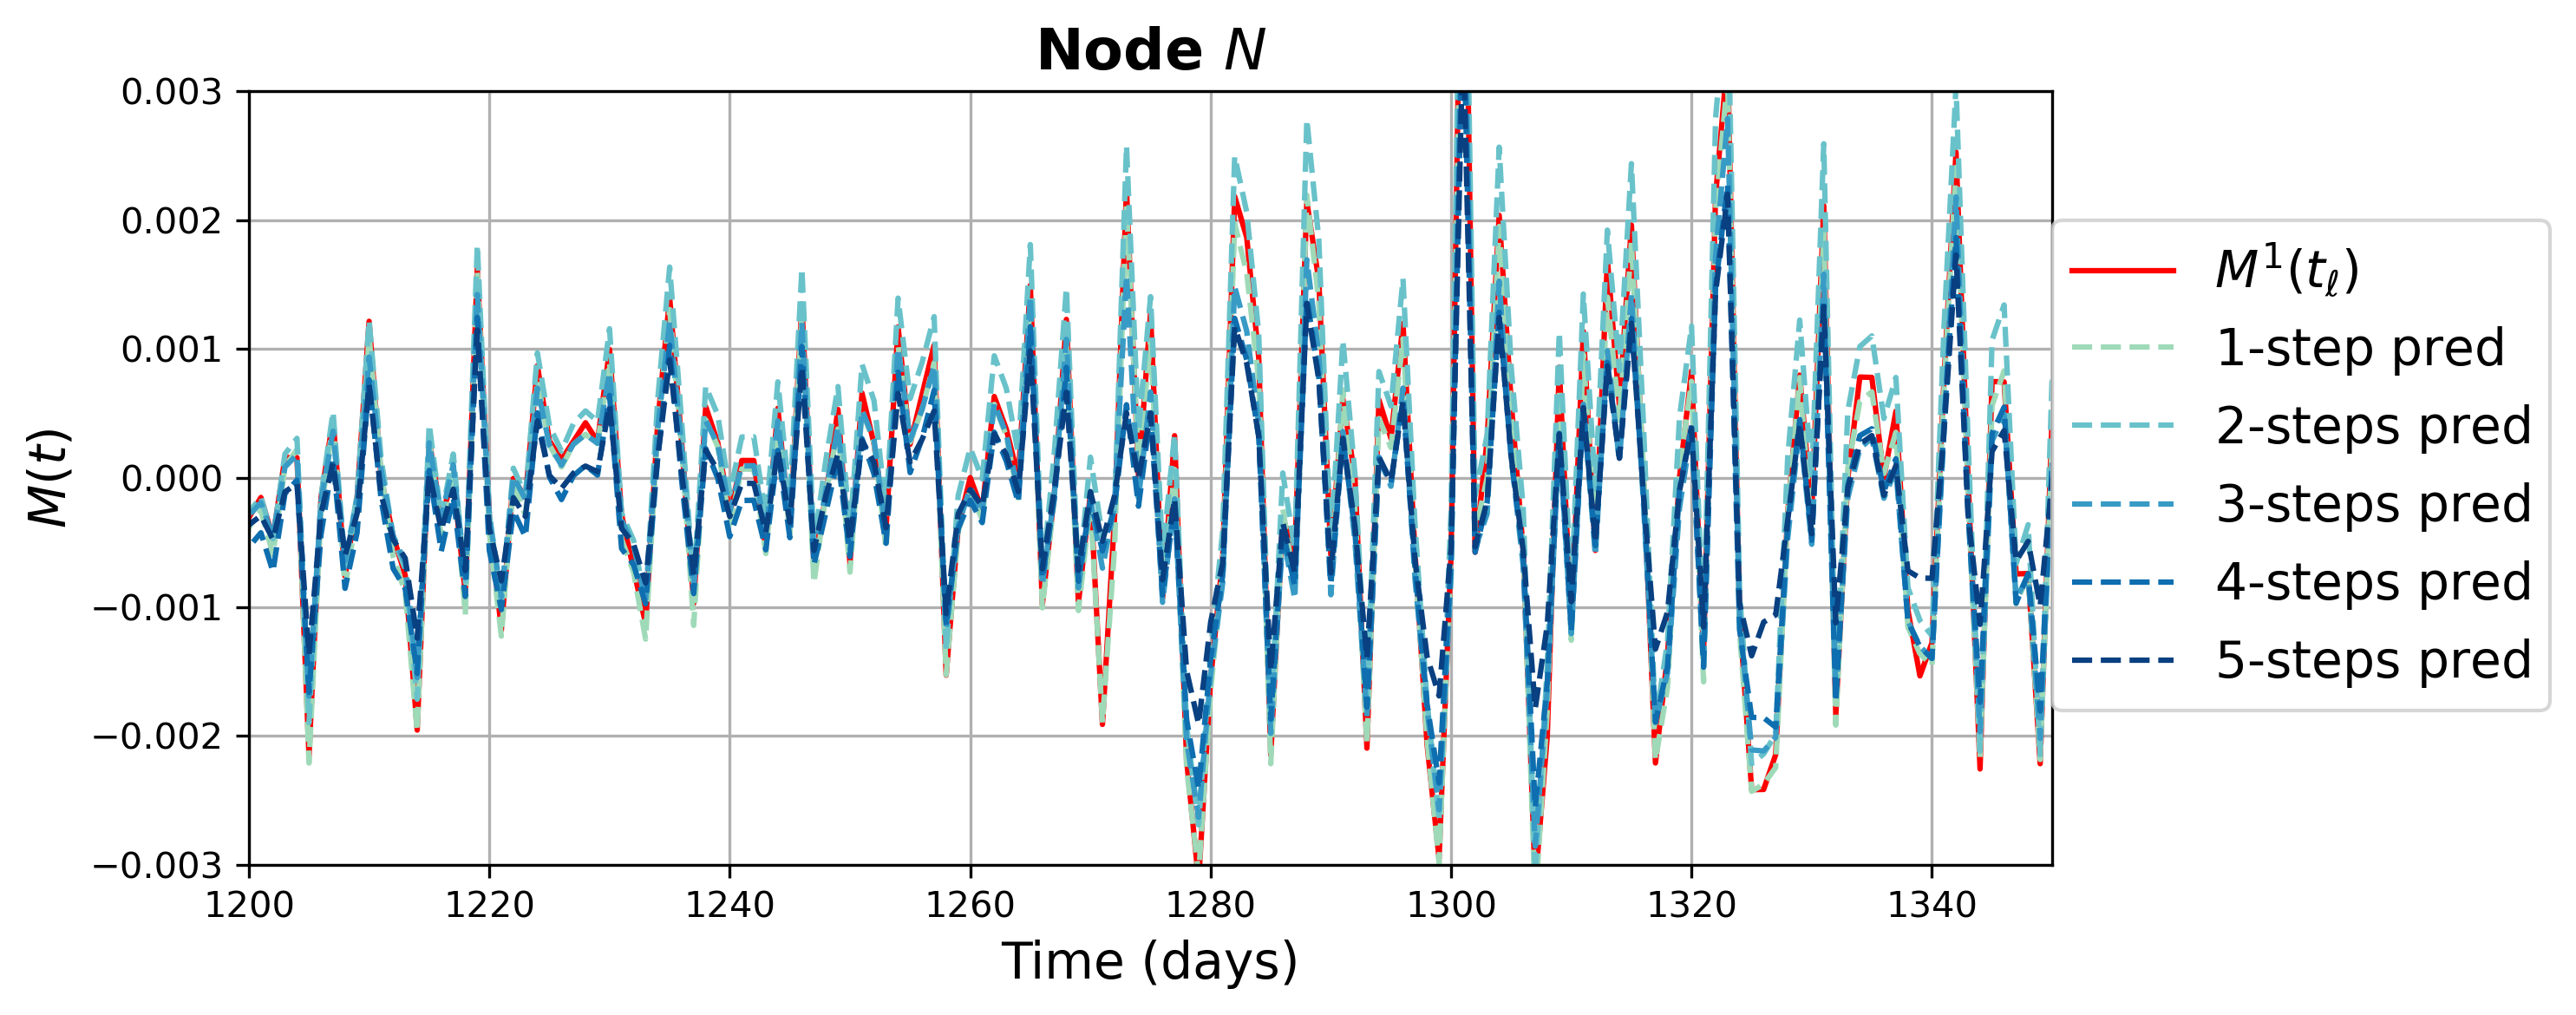

In [155]:
cmap = plt.cm.GnBu  # Choose a colormap (viridis in this case)
start, end = 0.4, 1  # Specify the start and end points of the colormap range
cmap_truncated = plt.cm.colors.LinearSegmentedColormap.from_list("truncated_cmap", cmap(np.linspace(start, end, 256)))

# Generate colors from the truncated colormap
colors = cmap_truncated(np.linspace(0, 1, 5))

plt.figure(figsize=(10,4), dpi=300)

plt.title('Node $N$', fontsize=16, fontweight='bold')
plt.plot(labels_test[4:,0,0], 'r-', label='$M^1(t_{\ell})$')
plt.plot(preds_test[4:,0,0], '--', c=colors[0], label='$1$-step pred')
plt.plot(preds_test[3:,0,1], '--', c=colors[1], label='$2$-steps pred')
plt.plot(preds_test[2:,0,2], '--', c=colors[2], label='$3$-steps pred')
plt.plot(preds_test[1:,0,3], '--', c=colors[3], label='$4$-steps pred')
plt.plot(preds_test[:,0,4], '--', c=colors[4], label='$5$-steps pred')
plt.xlim(1200,1350)
plt.ylim(-0.003,0.003)
plt.grid()
plt.legend(fontsize=14, loc=(1,0.2))
plt.xlabel('Time (days)', fontsize=14)
plt.ylabel('$M(t)$', fontsize=14)
plt.tight_layout()

#plt.savefig('for_the_sketch.pdf')

plt.show()

In [47]:
# #Get the predictions
print('Performing prediction')
train_margin_labels, train_benchmark, train_margin_predictions = utils.predictions(args, train_dataset, mymodel)
test_margin_labels, test_benchmark, test_margin_predictions = utils.predictions(args, test_dataset, mymodel)

np.save(f'./results/train_label_{args.steps_ahead}.npy',train_margin_labels)
np.save(f'./results/train_pred_{args.steps_ahead}.npy',train_margin_predictions)
np.save(f'./results/train_benchmark_{args.steps_ahead}.npy', train_benchmark)
np.save(f'./results/test_label_{args.steps_ahead}.npy',test_margin_labels)
np.save(f'./results/test_pred_{args.steps_ahead}.npy',test_margin_predictions)
np.save(f'./results/test_benchmark_{args.steps_ahead}.npy', test_benchmark)



Performing prediction


AttributeError: 'Namespace' object has no attribute 'steps_filename'

In [ ]:
20%4

In [ ]:
lr = 0.005
h=0
for i in range(9080):
    if i%130 == 0:
        lr*=0.9
        h+=1
    if h==60:
        break
    
    

In [ ]:
lr